In [ ]:
#importing required libraries
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
df = pd.read_csv("AirPodsPro_Reviews.csv")
df = df.drop_duplicates(subset=["Review Text"]).reset_index(drop=True)

print(f"Dataset Shape: {df.shape}")
print(df.head())


Using device: cpu
Dataset Shape: (100, 2)
                         Product Name  \
0  Apple AirPods Pro (2nd Generation)   
1  Apple AirPods Pro (2nd Generation)   
2  Apple AirPods Pro (2nd Generation)   
3  Apple AirPods Pro (2nd Generation)   
4  Apple AirPods Pro (2nd Generation)   

                                         Review Text  
0  Amazon - Pairing across Apple devices like iPh...  
1  Battery backup is solid with quick top-ups usi...  
2  Connection stability is excellent even when mo...  
3  Battery performance holds up well even after m...  
4  Noise cancellation is highly effective on flig...  


In [ ]:
#Creating a dummy Sentiment column
def assign_sentiment(text):
    text = text.lower()
    if any(w in text for w in ["good", "great", "amazing", "excellent", "love", "awesome", "best"]):
        return "positive"
    elif any(w in text for w in ["bad", "poor", "terrible", "hate", "worst", "disappointing"]):
        return "negative"
    return "neutral"

df["Sentiment"] = df["Review Text"].astype(str).apply(assign_sentiment)
print("\nSentiment Counts:\n", df["Sentiment"].value_counts())



Sentiment Counts:
 Sentiment
neutral     86
positive    14
Name: count, dtype: int64


In [ ]:
# Text Preprocessing and Tokenization
def clean_and_tokenize(text):
    text = re.sub(r"<.*?>", " ", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z']", " ", text)  # Remove non-letter characters
    return text.lower().split()

df["tokens"] = df["Review Text"].astype(str).apply(clean_and_tokenize)

C:\Users\91897\AppData\Local\Temp\ipykernel_48644\1400941979.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=df, palette="Set2")


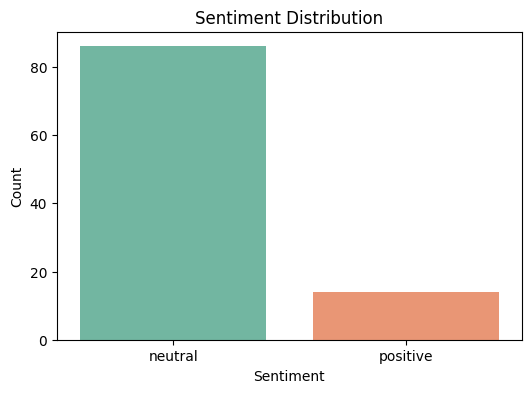

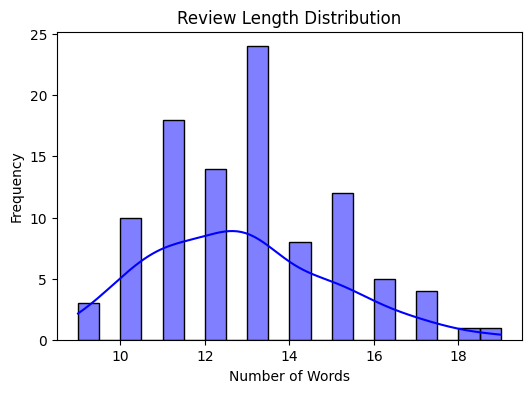

In [ ]:
# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


# Review length distribution
df["Review Length"] = df["Review Text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(df["Review Length"], bins=20, kde=True, color="blue")
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


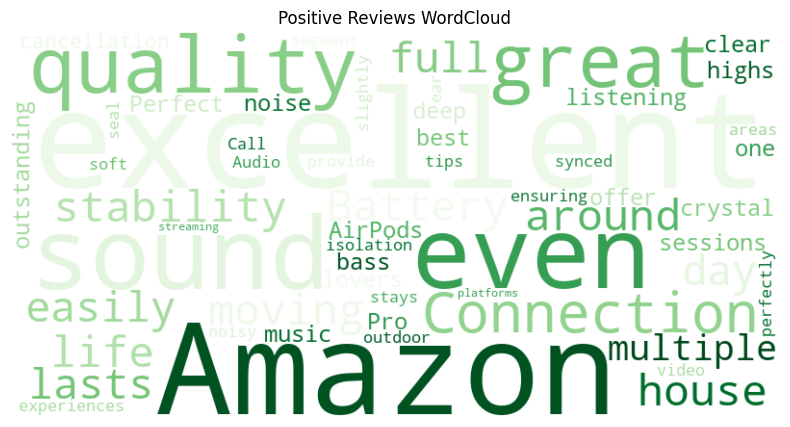

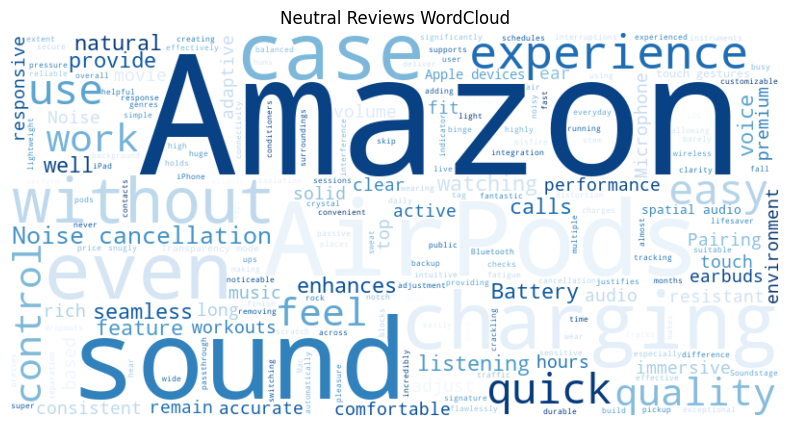

(WordCloud) Skipped: no text for Negative Reviews


In [ ]:
# WordClouds for each sentiment
from wordcloud import WordCloud
def plot_wordcloud(sentiment, color_map):
    text = " ".join(df[df["Sentiment"] == sentiment]["Review Text"])
    if len(text.strip()) == 0:
        print(f"(WordCloud) Skipped: no text for {sentiment.capitalize()} Reviews")
        return
    wc = WordCloud(width=800, height=400, background_color="white", colormap=color_map).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{sentiment.capitalize()} Reviews WordCloud")
    plt.show()

for s, cmap in zip(["positive", "neutral", "negative"], ["Greens", "Blues", "Reds"]):
    plot_wordcloud(s, cmap)


In [ ]:
# Vocabulary Building and Encoding
all_words = [w for tokens in df["tokens"] for w in tokens]
word_freq = Counter(all_words)
vocab = ["<PAD>", "<UNK>"] + [w for w, freq in word_freq.items() if freq >= 2]
word2idx = {w: i for i, w in enumerate(vocab)}

def encode_tokens(tokens, max_len=30):
    ids = [word2idx.get(w, word2idx["<UNK>"]) for w in tokens]
    return ids[:max_len] + [word2idx["<PAD>"]] * (max_len - len(ids))

df["encoded"] = df["tokens"].apply(encode_tokens)



In [ ]:
#encoding the labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Sentiment"])

# Train-Test Split
X = list(df["encoded"])
y = list(df["label"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# PyTorch Dataset and DataLoader
class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.encodings[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

train_dataset = ReviewsDataset(X_train, y_train)
test_dataset = ReviewsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=label_encoder.classes_,
    y=df["Sentiment"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [ ]:
# Neural Network Models
class SimpleNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)
        return self.fc(x)
#LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.fc(torch.cat((h[-2], h[-1]), dim=1))    

In [ ]:
# Training and Evaluation
def train_model(model, train_loader, test_loader, epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb).argmax(1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())


    print("\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


Training Simple Neural Network...
Epoch 1/5, Loss: 0.7246
Epoch 2/5, Loss: 0.6925
Epoch 3/5, Loss: 0.6918
Epoch 4/5, Loss: 0.6802
Epoch 5/5, Loss: 0.6706

Evaluation Metrics:
Accuracy: 0.8500
Precision: 0.4250
Recall: 0.5000
F1 Score: 0.4595

Classification Report:
               precision    recall  f1-score   support

     neutral       0.85      1.00      0.92        17
    positive       0.00      0.00      0.00         3

    accuracy                           0.85        20
   macro avg       0.42      0.50      0.46        20
weighted avg       0.72      0.85      0.78        20



c:\Users\91897\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\91897\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\91897\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

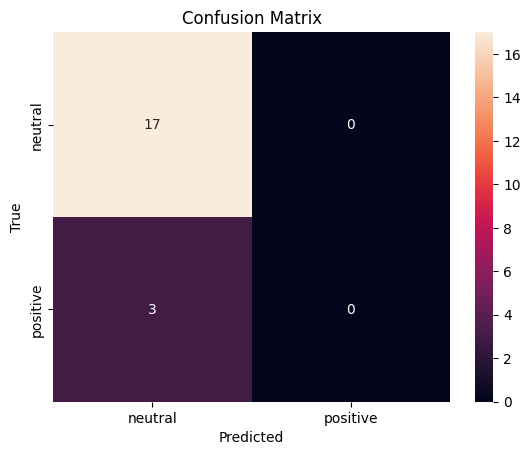


Training LSTM Classifier...
Epoch 1/5, Loss: 0.7083
Epoch 2/5, Loss: 0.6587
Epoch 3/5, Loss: 0.6208
Epoch 4/5, Loss: 0.5890
Epoch 5/5, Loss: 0.5785

Evaluation Metrics:
Accuracy: 0.7500
Precision: 0.5625
Recall: 0.5784
F1 Score: 0.5671

Classification Report:
               precision    recall  f1-score   support

     neutral       0.88      0.82      0.85        17
    positive       0.25      0.33      0.29         3

    accuracy                           0.75        20
   macro avg       0.56      0.58      0.57        20
weighted avg       0.78      0.75      0.76        20



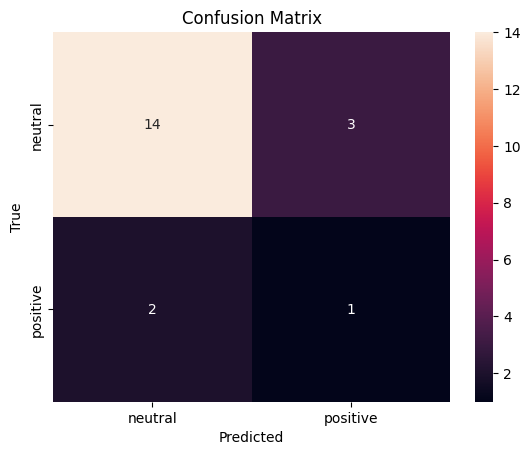

In [12]:
print("\nTraining Simple Neural Network...")
simple_model = SimpleNN(len(vocab), embed_dim=128, output_dim=len(label_encoder.classes_))
train_model(simple_model, train_loader, test_loader, epochs=5)

print("\nTraining LSTM Classifier...")
lstm_model = LSTMClassifier(len(vocab), embed_dim=128, hidden_dim=64, output_dim=len(label_encoder.classes_))
train_model(lstm_model, train_loader, test_loader, epochs=5)